In [ ]:
# If GCS data mount is not populated perform following steps in vm: 
"""
# Stop/Unmount any previous attempts 
# Try to unmount the directory in case a previous attempt left it mounted
# If this fails, it's fine, it just means it wasn't mounted.
fusermount -u ~/gcs_pdbbind_mount

# If /gcs_pdbbind_mount not visible in file system create dir for local mount point:
mkdir ~/gcs_pdbbind_mount

# Replace BUCKET_NAME and DIRECTORY_PATH
BUCKET_NAME="cs224w-2025-mae-gnn-bucket"
DIRECTORY_PATH="data/GEMS_pytorch_datasets" 

gcsfuse --only-dir "$DIRECTORY_PATH" -o allow_other --implicit-dirs "$BUCKET_NAME" ~/gcs_pdbbind_mount

#Verify the Mount:
ls -l ~/gcs_pdbbind_mount

# You should see your .pt files listed here, proving the mount worked.


In [1]:
!pip install torch_geometric pandas matplotlib
!pip install "numpy<2"

In [46]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [47]:
print("torch version:", torch.__version__)
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)

torch version: 1.13.1+cu117
numpy version: 1.26.4
pandas version: 2.3.3


In [128]:
# CONSTANTS

# Need to download Dataset.py from GEMS directory locally onto vm first
# git clone http://github.com/camlab-ethz/GEMS.git
# Define root path of cloned GEMS repo
GEMS_REPO_ROOT = os.path.expanduser('~/GEMS')

# Define the directory path where pre-processed .pt dataset files are located
DATA_DIR = os.path.join(os.path.expanduser('~'), 'gcs_pdbbind_mount')

# List of dataset files to analyze
DATASET_FILES = [
    # '00AEPL_casf2013.pt',
    # '00AEPL_casf2013_indep.pt',
    '00AEPL_casf2016.pt',
    '00AEPL_casf2016_indep.pt',
    '00AEPL_train_cleansplit.pt',
    # '00AEPL_train_pdbbind.pt'
]

ALL_ATOMS = ['B', 'C', 'N', 'O', 'P', 'S', 'Se', 'metal', 'halogen']

ATOM_HYBRIDIZATION_TYPES = ["HybridizationType.S", "HybridizationType.SP", "HybridizationType.SP2", "HybridizationType.SP2D", "HybridizationType.SP3", "HybridizationType.SP3D", "HybridizationType.SP3D2", "HybridizationType.UNSPECIFIED"]
TOTAL_NUM_H_S = ["Num_H.0", "Num_H.1", "Num_H.2", "Num_H.3", "Num_H.4"]
DEGREES = ['Degree.0', 'Degree.1', 'Degree.2', 'Degree.3', 'Degree.4', 'Degree.5', 'Degree.6', 'Degree.7', 'Degree.8', 'Degree.OTHER']
CHIRALITIES = ['Chirality.CHI_UNSPECIFIED', 'Chirality.CHI_TETRAHEDRAL_CW', 'Chirality.CHI_TETRAHEDRAL_CCW', 'Chirality.OTHER']

AMINO_ACIDS = ["ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE", "LEU",
            "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"]

LIGAND_FEATURE_MAP = ALL_ATOMS + ["IsInRing"] + ATOM_HYBRIDIZATION_TYPES + \
                    ["FORMAL_CHARGE", "IS_AROMATIC", "MASS/100", ] + TOTAL_NUM_H_S + \
                    DEGREES + CHIRALITIES
FULL_FEATURE_MAP = LIGAND_FEATURE_MAP + AMINO_ACIDS

EDGE_FEATURE_MAP = ["COVALENT_BOND", "SELF_LOOP", "NON-COVALENT_BOND", "EDGE_LENGTH/10", "EDGE_LENGTH/10", "EDGE_LENGTH/10", "EDGE_LENGTH/10" ] + \
                   ["BOND_TYPE_0", "BOND_TYPE_1.0", "BOND_TYPE_1.5", "BOND_TYPE_2.0", "BOND_TYPE_3.0"] + \
                   ["IS_CONJUGATED", "IS_IN_RING", "BOND_STEREO.NONE", "BOND_STEREO.ANY", "BOND_STEREO.E", "BOND_STEREO.Z", "BOND_STEREO.CIS", "BOND_STEREO.TRANS"]


In [49]:
# Dynamic Import of Custom Datasets Class
# Add the directory to Python's search path.
print(f"Attempting to load custom Dataset class...")

try:
  # Add GEMS root to sys.path
  if GEMS_REPO_ROOT not in sys.path:
    sys.path.append(GEMS_REPO_ROOT)
    print(f"Added {GEMS_REPO_ROOT} to sys.path")

    # Import custom Dataset class from the cloned repo
    from Dataset import Dataset as GEMS_Dataset
    print("Successfully imported custom Dataset class")

    # Import the necessarty PyG components
    from torch_geometric.data import Data #, Dataset

except ImportError as e:
    raise RuntimeError(f"FATAL ERROR importing GEMS Dataset class: {e}")


Attempting to load custom Dataset class...


In [84]:
def extract_metrics(data_list):
    """Iterates through list of GEMS datasets and extracts metrics."""
    metrics = []

    num_features = data_list[0].x.size(1)
    for i, data in enumerate(data_list):
        # Affinity is the y label
        affinity = data.y.item()

        # ID (Assuming is stored in 'id' attribute)
        pdb_id = getattr(data, 'id', f'Complex_{i}')

        # Extract Graph Size Metrics
        # node features (x): shape is [num_atoms, num_features]
        num_nodes = data.x.size(0)

        # Edge index: shape is: [2, num_edges]
        num_edges = data.edge_index.size(1)
    
        [n_nodes, n_ligand_nodes, n_protein_nodes] = data.n_nodes.numpy()

        # Isolate ligand rows
        ligand_x = data.x[:n_ligand_nodes]
        
        # Slice the tensor to only get the atom on-hot columns
        ligand_heavy_atoms_oh = ligand_x[:, :len(ALL_ATOMS)]
        is_heavy_atom = (ligand_heavy_atoms_oh.any(dim=1)).float()
        heavy_atom_count = is_heavy_atom.sum().item()

        # Isolate protein rows
        protein_x = data.x[n_ligand_nodes:]
        
        # Slice the tensor to only get the amino acid one-hot columns (last 20 cols)
        protein_aa_oh = protein_x[:, num_features - len(AMINO_ACIDS):]
        protein_aa_counts = protein_aa_oh.sum(dim=0)
        
        # convert to frequency normalization
        protein_aaf = (protein_aa_counts/ n_protein_nodes).cpu().numpy().tolist()
        
        # Feature counts
        feature_counts_tensor = torch.sum(data.x, dim=0)

        # Append the aggregated features to the list
        record = {
            'PDB_ID': pdb_id,
            'Affinity_pKi_pKd': affinity,
            'Num_Nodes': num_nodes,
            'Num_Ligand_Atoms': n_ligand_nodes,
            'Num_Ligand_Heavy_Atoms': heavy_atom_count,
            'Num_Protein_Amino_Acid_Nodes': n_protein_nodes,
            'Protein_Amino_Acid_Frequency': protein_aaf,
            'Num_Interactions': num_edges,
            'Density': num_edges / num_nodes,
        }

        # Add feature counts dynamically
        for j, feature_name in enumerate(FULL_FEATURE_MAP):
            record[feature_name] = feature_counts_tensor[j].item()

        metrics.append(record)

    return pd.DataFrame(metrics)

In [54]:
def run_data_analysis(df, dataset_name):
    """Performs data analysis on dataframe and produces visualizations"""

    print(f"Analyzing {dataset_name} dataset (N={len(df)})...")

    # Affinity Distribution
    print("\n[1] Affinity Distribution")
    print(df['Affinity_pKi_pKd'].describe())

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    df['Affinity_pKi_pKd'].hist(bins=50)
    plt.title(f'{dataset_name}: Affinity Distribution')
    plt.xlabel('Binding Affinity (pKi/pKd)')
    plt.ylabel('Frequency')

    # Graph Size Metrics
    print("\n[2] Graph Size Metrics")
    print(df[['Num_Nodes', 'Num_Interactions', 'Density']].describe())

    df[['Num_Nodes', 'Num_Interactions', 'Density']].hist(bins=50)
    
    plt.tight_layout()
    plt.show()

    # Protein Diversity
    # Use PDB_ID count to determine protein complexes
    unique_complexes = df['PDB_ID'].nunique()
    print(f"\n[3] Protein Diversity: {unique_complexes} unique proteins")
    print(f"Redundancy Ratio (Total N / Unique N): {len(df) / unique_complexes:.2f}")

    # Node Feature Frequency
    # Summing up total count for the top 5 most frequent features
    feature_cols = [col for col in df.columns if col in FULL_FEATURE_MAP]
    top_5_features = df[feature_cols].sum().nlargest(5).index.tolist()

    # Edge Feature Frequency
    # TODO
    
    print("\n[4] Node Feature Frequency")
    print(f"Top 5 Features: {', '.join(top_5_features)}")
    print("--------------------------\n")


In [114]:
def run_ligand_data_analysis(df, dataset_name):
    column_name = 'Ligand Heavy Atom Count'
    df.columns = [column_name]
    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=df,
        x=column_name,
        kde=True,
        bins=25,
        color='#1f77b4',
        edgecolor='black',
        linewidth=0.8
    )
    
    heavy_atom_mean_count = df.mean().item()
    plt.title(f'Distribution of Ligand Heavy Atom Counts')
    plt.xlabel('Number of Heavy Atoms per Ligand', fontsize=12)
    plt.ylabel('Frequency (Number of Ligands)', fontsize=12)
    plt.axvline(heavy_atom_mean_count, color='red', linestyle='--', label=f'Mean: {heavy_atom_mean_count:.2f} Atoms')
    plt.legend()
    plt.grid(axis='y', linestyle=':', alpha=0.6)
    plt.tight_layout()
    
    print("Summary Statistics for Ligand Heavy Atom Counts:")
    print(df.describe().transpose())
    
    plt.show()


In [125]:
def run_protein_data_analysis(df, dataset_name):
    """
    Analyzes and visualizes protein pocket diversity using PCA and t-SNE 
    on the Amino Acid Frequency (AAF) profiles provided in the input DataFrame.
    """
    # Dimensionality Reduction (PCA & t-SNE)
    # PCA is used first to reduce noise and provide a linear benchmark
    df.columns = AMINO_ACIDS
    aaf_values = np.array(df.values, dtype=np.float64)

    if aaf_values.shape[1] != len(AMINO_ACIDS):
        print(f"Error: Expected {len(AMINO_ACIDS)} columns for protein amino acid features, got {aaf_values.shape[1]}")
        return
    
    pca = PCA(n_components=5)
    pca_5d = pca.fit_transform(aaf_values)

    # t-SNE (Non-linear) is used to find intrinsic clusters for visualization
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
    tsne_2d = tsne.fit_transform(pca_5d) 

    # Create DataFrame for scatter plotting
    df_diversity = pd.DataFrame(tsne_2d, columns=['t-SNE Dimension 1', 't-SNE Dimension 2'])

    # Plotting the Cluster Diversity
    plt.figure(figsize=(10, 8))

    sns.scatterplot(
        data=df_diversity, 
        x='t-SNE Dimension 1', 
        y='t-SNE Dimension 2', 
        alpha=0.7, 
        s=50,
        edgecolor='w'
    )
    plt.title(f'{dataset_name} Pocket Diversity (t-SNE of Amino Acid Frequencies, N={aaf_values.shape[0]})', fontsize=16)
    plt.xlabel('t-SNE Dimension 1', fontsize=12)
    plt.ylabel('t-SNE Dimension 2', fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()


    # TOP 10 NODE FEATURE (AMINO ACID) ANALYSIS ---

    # Calculate the mean frequency of each amino acid across ALL pockets
    mean_aaf = df.mean()
    df_mean_aaf = pd.DataFrame({
        'Amino Acid': mean_aaf.index,
        'Mean Frequency': mean_aaf.values
    }).sort_values(by='Mean Frequency', ascending=False)

    # Plot the top 10 most common amino acids
    plt.figure(figsize=(12, 6))

    sns.barplot(
        data=df_mean_aaf.head(10),
        x='Amino Acid',
        y='Mean Frequency',
        hue='Amino Acid',
        palette='rocket',
        legend=False
    )
    plt.title(f'Top 10 Most Frequent Amino Acids in {dataset_name} Binding Pockets', fontsize=14)
    plt.ylabel('Mean Frequency (Proportion)', fontsize=12)
    plt.xlabel('Amino Acid', fontsize=12)
    plt.tight_layout()
    plt.show()

    print("\n--- Summary of Amino Acid Frequency in Pockets ---")
    print(df_mean_aaf.head(10))
    print(f"\nTotal variance explained by first 5 PCA components: {pca.explained_variance_ratio_.sum()*100:.2f}%")

In [58]:
def run_data_analysis_across_datasets(all_data_df):
    plt.figure(figsize=(8,5))
    sns.boxplot(
        x='Dataset',
        y='Affinity_pKi_pKd',
        data=all_data_df,
    )

    plt.title('Binding Affinity Distribution Across Datasets')
    plt.xlabel('Dataset Split')
    plt.ylabel('Binding Affinity ($pK_i$ or $pK_d$)')
    plt.grid(axis='y', linestyle='--')
    plt.show()


Loading 00AEPL_casf2016.pt [1/3]...
Example data object type: <class 'torch_geometric.data.data.Data'>
Analyzing 00AEPL_casf2016.pt dataset (N=282)...

[1] Affinity Distribution
count    282.000000
mean       0.406474
std        0.135676
min        0.129375
25%        0.308750
50%        0.406250
75%        0.502969
max        0.738750
Name: Affinity_pKi_pKd, dtype: float64

[2] Graph Size Metrics
        Num_Nodes  Num_Interactions     Density
count  282.000000        282.000000  282.000000
mean    45.070922        384.184397    8.444645
std     13.671096        130.447634    0.741061
min     19.000000        144.000000    6.294118
25%     35.000000        282.250000    7.974138
50%     43.000000        369.000000    8.500000
75%     52.000000        460.000000    9.036944
max    104.000000        829.000000    9.987952


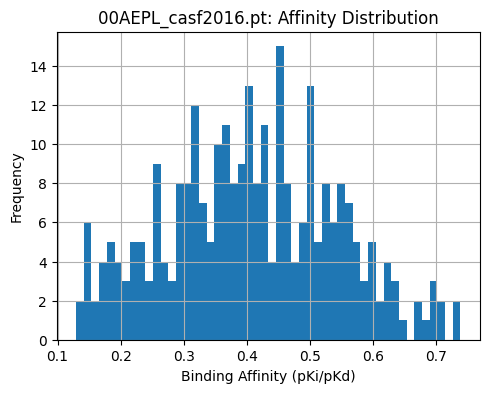

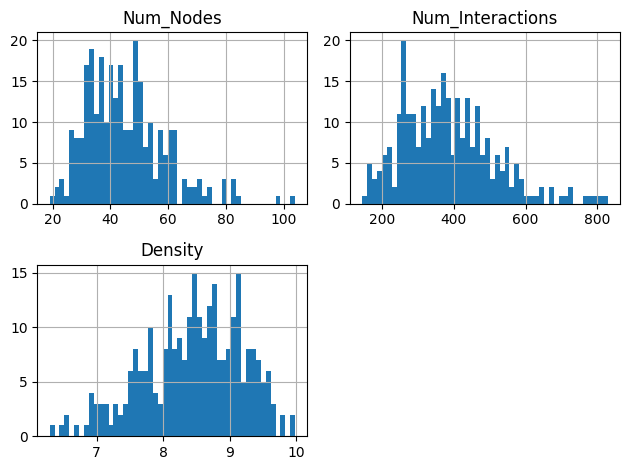


[3] Protein Diversity: 282 unique proteins
Redundancy Ratio (Total N / Unique N): 1.00

[4] Node Feature Frequency
Top 5 Features: Chirality.CHI_UNSPECIFIED, C, HybridizationType.SP2, IsInRing, Degree.2
--------------------------



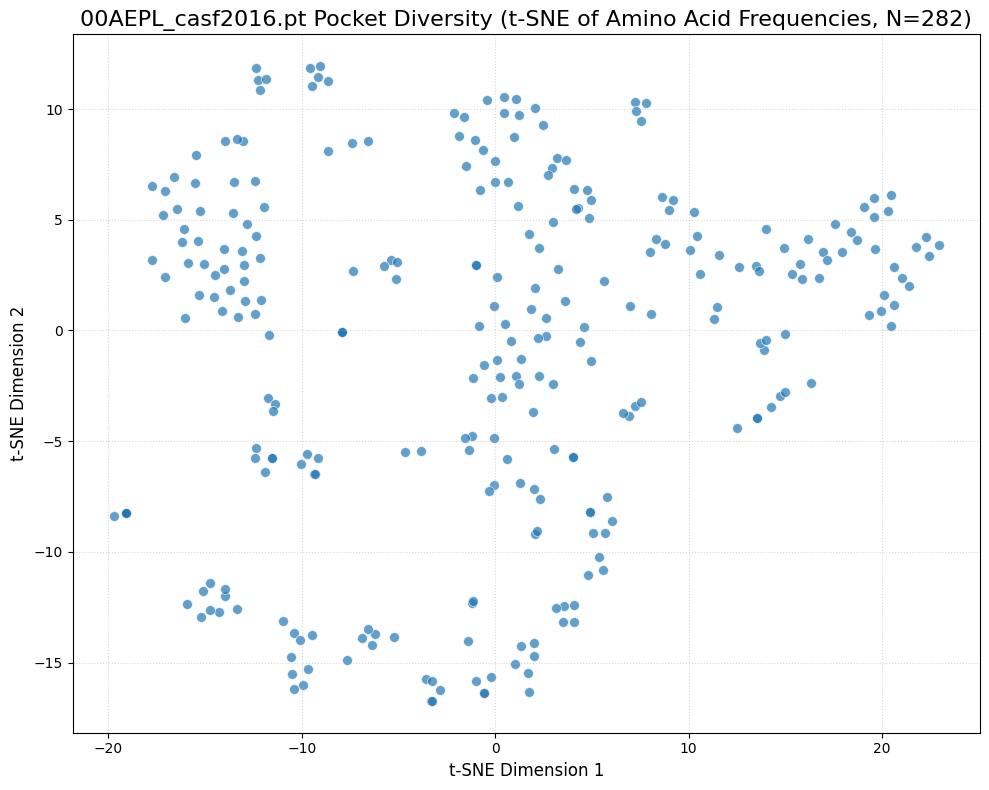

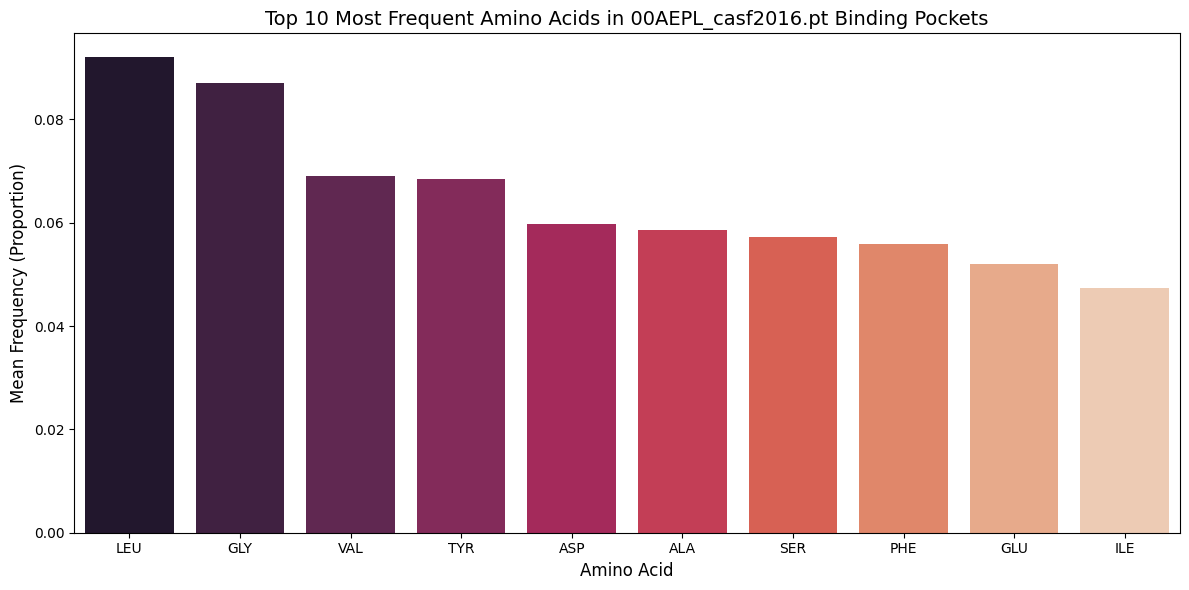


--- Summary of Amino Acid Frequency in Pockets ---
   Amino Acid  Mean Frequency
10        LEU        0.092034
7         GLY        0.086992
19        VAL        0.069007
18        TYR        0.068394
3         ASP        0.059725
0         ALA        0.058553
15        SER        0.057229
13        PHE        0.055808
6         GLU        0.052014
9         ILE        0.047338

Total variance explained by first 5 PCA components: 54.43%
Summary Statistics for Ligand Heavy Atom Counts:
                         count       mean       std  min   25%   50%   75%  \
Ligand Heavy Atom Count  282.0  24.553191  9.739983  9.0  17.0  23.0  30.0   

                          max  
Ligand Heavy Atom Count  67.0  


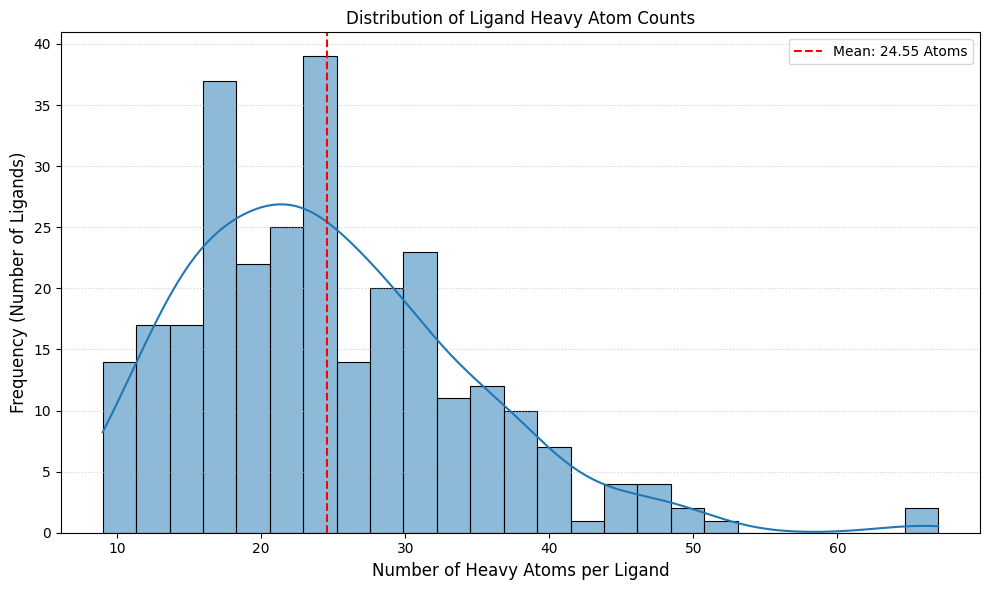

Loading 00AEPL_casf2016_indep.pt [2/3]...
Example data object type: <class 'torch_geometric.data.data.Data'>
Analyzing 00AEPL_casf2016_indep.pt dataset (N=142)...

[1] Affinity Distribution
count    142.000000
mean       0.398002
std        0.145711
min        0.129375
25%        0.291719
50%        0.397500
75%        0.500938
max        0.708125
Name: Affinity_pKi_pKd, dtype: float64

[2] Graph Size Metrics
        Num_Nodes  Num_Interactions     Density
count  142.000000        142.000000  142.000000
mean    45.288732        382.401408    8.367395
std     14.981587        137.601442    0.752651
min     19.000000        159.000000    6.294118
25%     33.250000        266.250000    7.833333
50%     44.000000        369.000000    8.454545
75%     54.000000        471.750000    8.922988
max    104.000000        812.000000    9.833333


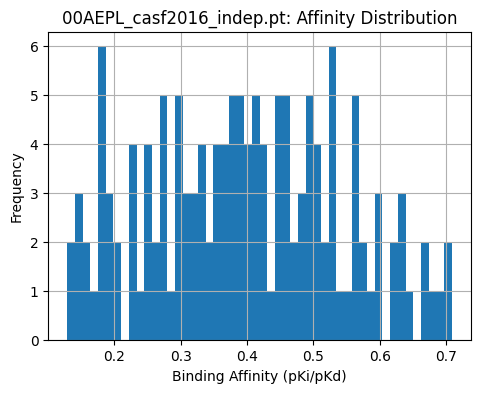

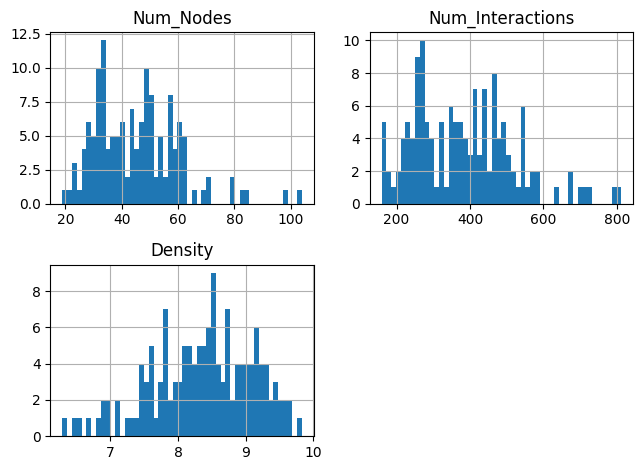


[3] Protein Diversity: 142 unique proteins
Redundancy Ratio (Total N / Unique N): 1.00

[4] Node Feature Frequency
Top 5 Features: Chirality.CHI_UNSPECIFIED, C, HybridizationType.SP2, IsInRing, Degree.2
--------------------------



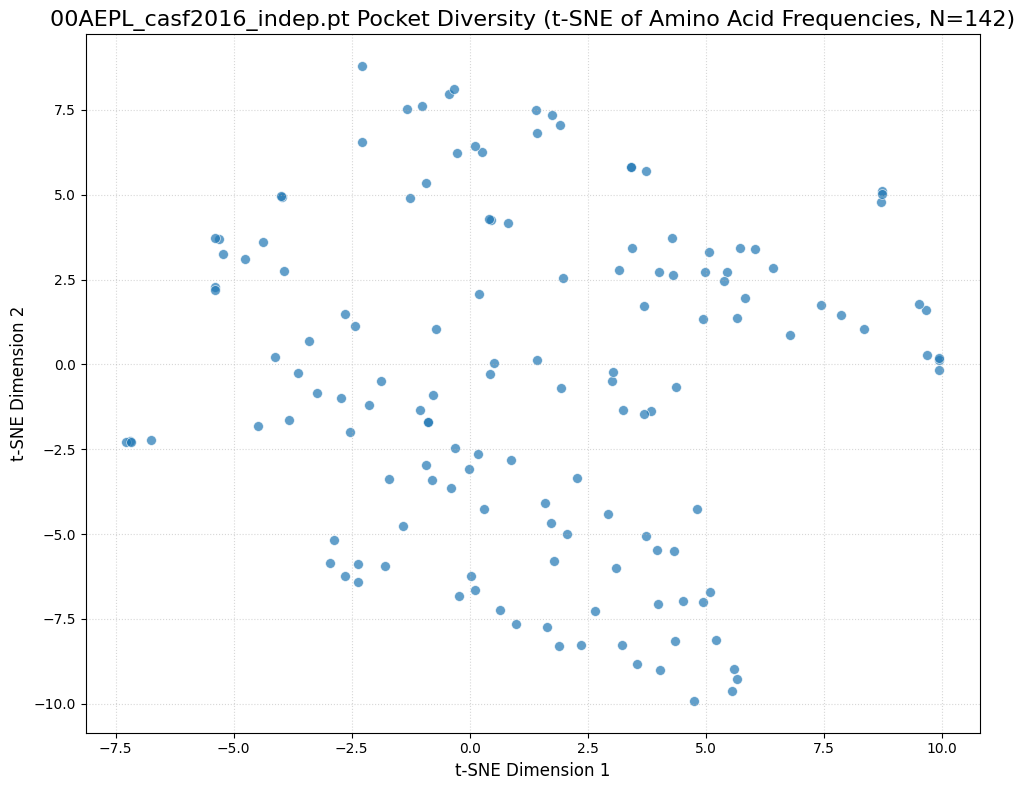

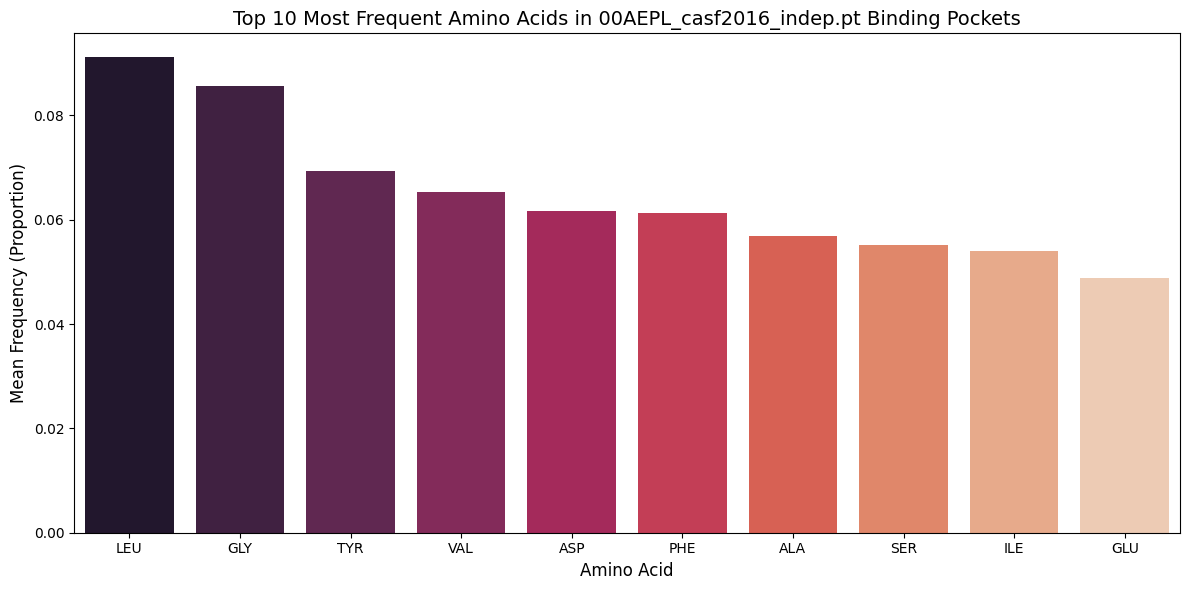


--- Summary of Amino Acid Frequency in Pockets ---
   Amino Acid  Mean Frequency
10        LEU        0.091175
7         GLY        0.085578
18        TYR        0.069348
19        VAL        0.065334
3         ASP        0.061588
13        PHE        0.061334
0         ALA        0.056798
15        SER        0.055114
9         ILE        0.053918
6         GLU        0.048893

Total variance explained by first 5 PCA components: 57.23%
Summary Statistics for Ligand Heavy Atom Counts:
                         count  mean        std  min   25%   50%   75%   max
Ligand Heavy Atom Count  142.0  25.0  10.440646  9.0  16.0  24.0  31.0  67.0


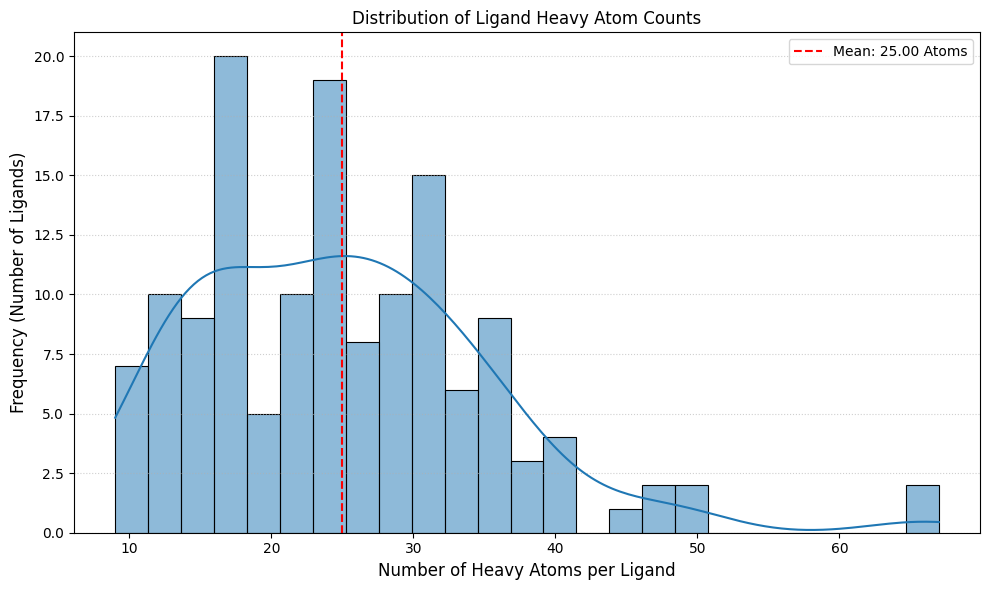

Loading 00AEPL_train_cleansplit.pt [3/3]...
Example data object type: <class 'torch_geometric.data.data.Data'>
Analyzing 00AEPL_train_cleansplit.pt dataset (N=16491)...

[1] Affinity Distribution
count    16491.000000
mean         0.397314
std          0.113791
min          0.025000
25%          0.316250
50%          0.401250
75%          0.480000
max          0.937500
Name: Affinity_pKi_pKd, dtype: float64

[2] Graph Size Metrics
          Num_Nodes  Num_Interactions       Density
count  16491.000000      16491.000000  16491.000000
mean      55.562064        441.445758      8.084155
std       26.172172        180.658574      1.025829
min       13.000000         57.000000      3.600000
25%       40.000000        320.000000      7.500000
50%       50.000000        418.000000      8.225806
75%       63.000000        526.000000      8.812500
max      249.000000       1435.000000     10.968254


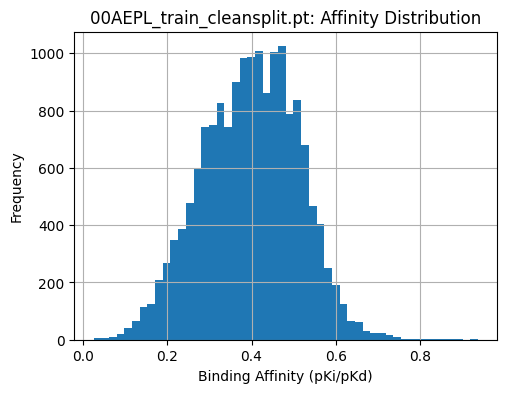

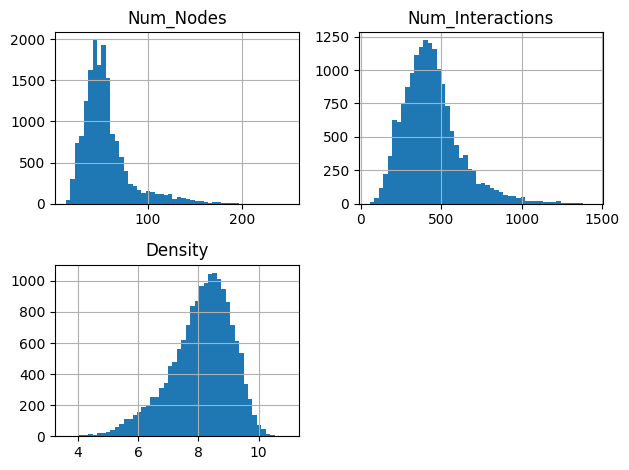


[3] Protein Diversity: 16491 unique proteins
Redundancy Ratio (Total N / Unique N): 1.00

[4] Node Feature Frequency
Top 5 Features: Chirality.CHI_UNSPECIFIED, C, HybridizationType.SP2, IsInRing, Degree.2
--------------------------



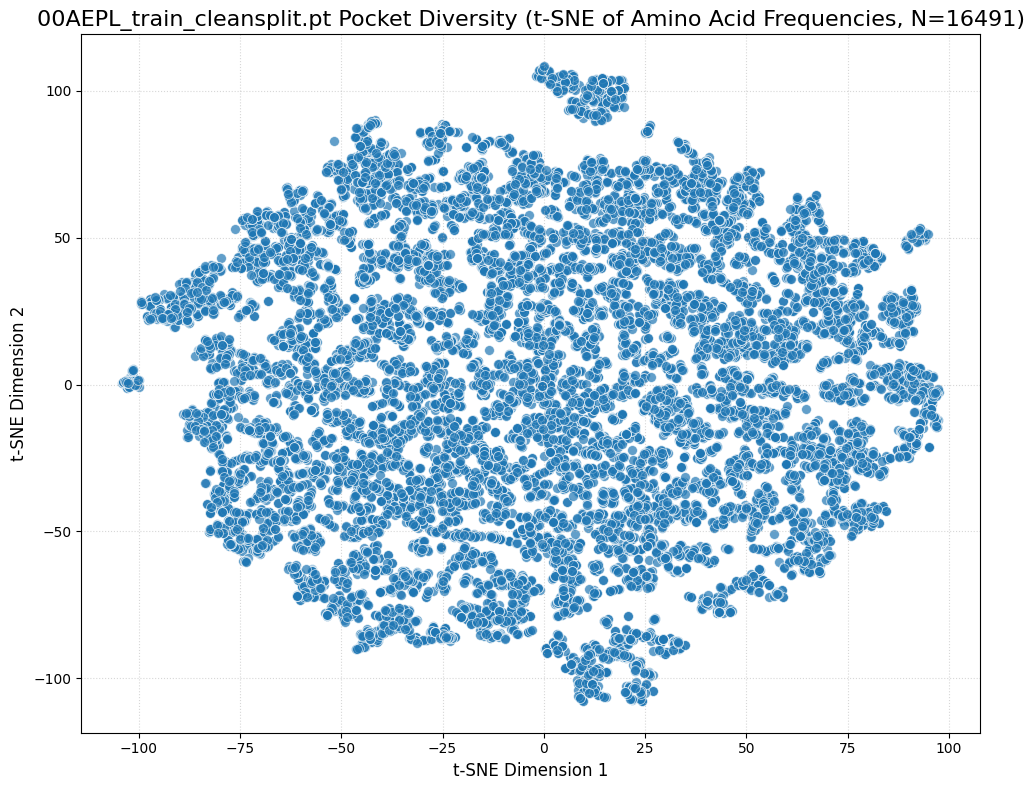

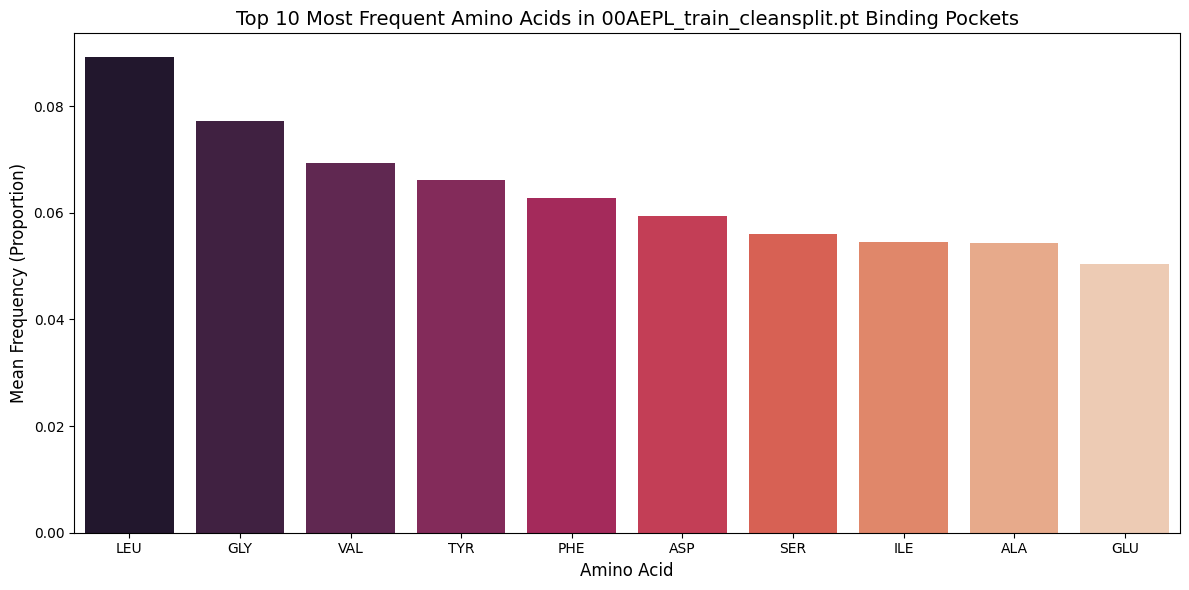


--- Summary of Amino Acid Frequency in Pockets ---
   Amino Acid  Mean Frequency
10        LEU        0.089199
7         GLY        0.077189
19        VAL        0.069389
18        TYR        0.066213
13        PHE        0.062685
3         ASP        0.059379
15        SER        0.056110
9         ILE        0.054456
0         ALA        0.054273
6         GLU        0.050442

Total variance explained by first 5 PCA components: 44.64%
Summary Statistics for Ligand Heavy Atom Counts:
                           count       mean        std  min   25%   50%   75%  \
Ligand Heavy Atom Count  16491.0  33.928143  22.846555  5.0  21.0  28.0  37.0   

                           max  
Ligand Heavy Atom Count  224.0  


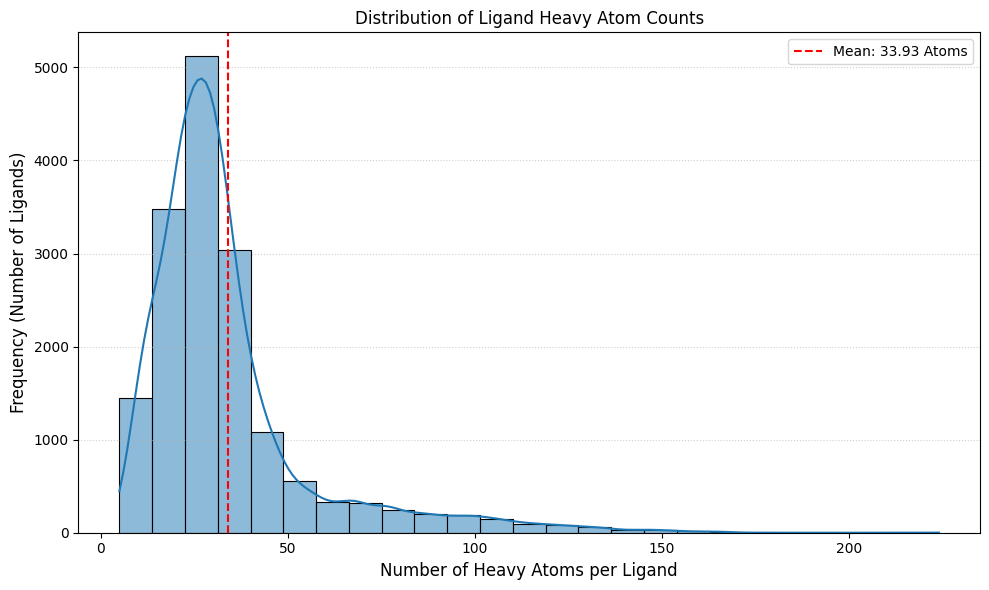

--------------| Data analysis completed! |------------


In [129]:
# Main loop
if not os.path.exists(DATA_DIR):
    raise RuntimeError(f"FATAL ERROR: Path {DATA_DIR} does not exist.")

all_data_df = pd.DataFrame({"Affinity_pKi_pKd": [], "Dataset": []})

for i, filename in enumerate(DATASET_FILES):
    data_filepath = os.path.join(DATA_DIR, filename)

    if not os.path.exists(data_filepath):
        print(f"WARNING: File not found: {data_filepath}. Skipping...")
        continue

    print(f"Loading {filename} [{i+1}/{len(DATASET_FILES)}]...")
    try:
        # Load data_list
        data_list = torch.load(data_filepath)
        print(f"Example data object type: {type(data_list[0])}")

        # Run analysis
        df = extract_metrics(data_list)
        run_data_analysis(df, filename)
        protein_aaf_df = df['Protein_Amino_Acid_Frequency'].apply(pd.Series)
        run_protein_data_analysis(protein_aaf_df, filename)

        run_ligand_data_analysis(df[['Num_Ligand_Heavy_Atoms']], filename)
        all_data_df = pd.concat([all_data_df, df[["Affinity_pKi_pKd"]].assign(Dataset=filename)])

    except Exception as e:
        print(f"\nFAILED PROCESSING {filename}: {e}")

print("--------------| Data analysis completed! |------------")

## Target Variable Analysis

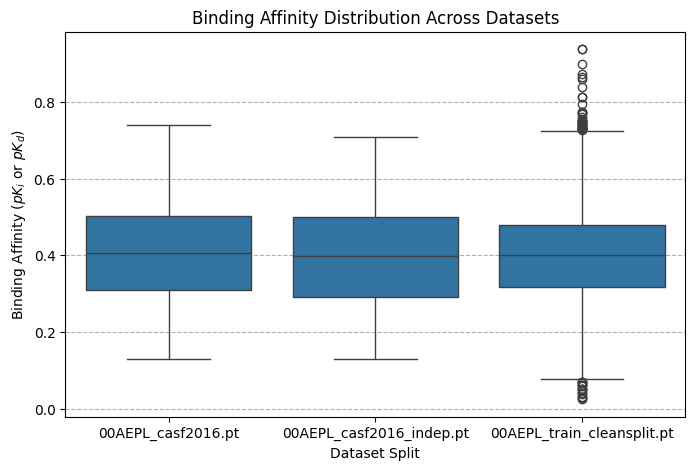

In [130]:
run_data_analysis_across_datasets(all_data_df)

## Binding Affinity Distribution Across Datasets
The median affinity across the datasets is similar, giving confidence that the average binding strength of the test sets is similar to the training set.  A difference would indicate potential bias.  

The circles outside of the whiskers indicates the presence of outliers in the training set, which means the model will have to learn from a wide range of values.

A follow up will be to validate the outlier data points, to confirm they are not due to errors.